In [5]:
!pip3 install --upgrade keras-nlp

In [1]:
import platform
import keras
import tensorflow as tf

In [2]:
# Sometimes, the learning with tensorflow-metal does not converge.
# @see
# - https://forums.developer.apple.com/forums/thread/736187
# - https://forums.developer.apple.com/forums/thread/701056
# - https://forums.developer.apple.com/forums/thread/742157
# Therefore, it might be best to execute learning without metal and execute learning again in the last tuning phase.
if platform.processor() == "arm":
    print("This is running on M1/M2 mac.")
    tf.config.set_visible_devices([], 'GPU')
print(f"Tensorflow {tf.__version__} is running. This notebook was written with Tensorflow 2.15.0.")
print(f"Keras {keras.__version__} is running. This notebook was written with Keras 2.15.0.") 

This is running on M1/M2 mac.
Tensorflow 2.14.1 is running. This notebook was written with Tensorflow 2.15.0.
Keras 2.14.0 is running. This notebook was written with Keras 2.15.0.


***

In [12]:
import keras_nlp
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

def plot(history, title=None):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    """
    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(["loss", "accuracy"]):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()

    print(
        np.min(history.history["val_loss"]),
        "The best number of epocs for the validation loss is",
        np.argmin(history.history["val_loss"]) + 1,
    )
    print(
        np.max(history.history["val_accuracy"]),
        "The best number of epocs for the validation accuracy is",
        np.argmax(history.history["val_accuracy"]) + 1,
    )

def load_ag_news_subset(batch_size, shuffle=False):
    """
    Load ag_news_subset dataset.
    :param batch_size: the number of batch size.
    :param shuffle: if True, it is shuffled.
    :return: a dataset object.
    """
    BUFFER_SIZE = 10000
    dataset, info = tfds.load(
        'ag_news_subset',
        with_info=True,
        as_supervised=False
    )
    train_dataset, test_dataset = dataset['train'], dataset['test']

    if shuffle:
        # If shuffle is hopefully used,
        # the reshuffle_each_iteration parameter must be False.
        # Or the partial training dataset and the validation set are contaminated.
        train_dataset = train_dataset.shuffle(
            buffer_size=BUFFER_SIZE,
            reshuffle_each_iteration=False
        )
        test_dataset = test_dataset.shuffle(
            buffer_size=BUFFER_SIZE,
            reshuffle_each_iteration=False
        )

    partial_train_dataset = train_dataset.take(len(train_dataset) // 10 * 8)
    val_dataset = train_dataset.skip(len(train_dataset) // 10 * 8)

    print("The number of training set is", len(train_dataset))
    print("The number of partial training set is", len(partial_train_dataset))
    print("The number of validation set is", len(val_dataset))

    # In advance, batch and prefetch are called. Or, they are needed for each use.
    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    partial_train_dataset = partial_train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, partial_train_dataset, val_dataset, test_dataset

def tuplize(x):
    """
    Transform a row from the dataset to learn.
    :param x: a single row of the dataset.
    :return: a tuple of the feature and the target.
    """
    return (
        x['title'] + ' ' + x['description'],# x: feature
        x['label']# y: target
    )

def build_encoder(train_dataset, max_tokens=25000, output_mode='multi_hot', seq_length=50):
    """
    Build a TextVectorization layer for preprocessing of text/token.
    :param train_dataset: the tokenized text data.
    :param max_tokens: the number of token.
    :param output_mode: for the param of TextVectorization. multi_hot/int is expected.
    :return: a TextVectorization layer.
    """
    encoder = layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode=output_mode,
        output_sequence_length=seq_length
    )
    encoder.adapt(train_dataset.map(lambda x: x['description'] + ' ' + x['title']))
    # The test set should not be adapted.
    #encoder.adapt(test_dataset.map(lambda x: x['description'] + ' ' + x['title']))
    return encoder

def build_model(
        train_dataset,
        max_tokens=25000,
        output_dim=128,
        dense_dim=32,
        num_heads=2,
        seq_length=50,
        name=None):
    """
    Build a sequential model with the TextVectorization and Embedding.
    :param train_dataset: the tokenized text data.
    :param max_tokens: the number of token.
    :param output_dim: the number of dimension for embedding.
    :param units: the number of units.
    :param name: the name of the model.
    :return: a sequential model.
    """
    inputs = layers.Input(shape=(1,), dtype="string")
    encoder = build_encoder(
        train_dataset=train_dataset,
        max_tokens=max_tokens,
        output_mode='int',
        seq_length=output_dim
    )
    x = encoder(inputs)
    token_embeddings = keras.layers.Embedding(
        input_dim=max_tokens,
        output_dim=output_dim,
        mask_zero=True
    )(x)
    position_embeddings = keras_nlp.layers.PositionEmbedding(
        sequence_length=output_dim
    )(token_embeddings)
    x = token_embeddings + position_embeddings
    x = keras_nlp.layers.TransformerEncoder(
        intermediate_dim=dense_dim,
        num_heads=num_heads
    )(inputs=x)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(4, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    model.compile(
        optimizer="adam",
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'],
    )


    # model = tf.keras.Sequential(name=name)
    # model.add(encoder)
    # model.add(keras.layers.Embedding(input_dim=max_tokens, output_dim=output_dim, mask_zero=True))
    # #model.add(TransformerEncoder(embed_dim=output_dim, dense_dim=dense_dim, num_heads=num_heads))
    # # Instead of the self-implementation, keras_nlp is used as below.
    # model.add(keras_nlp.layers.TransformerEncoder(intermediate_dim=dense_dim, num_heads=num_heads))
    # model.add(layers.GlobalMaxPooling1D())
    # model.add(layers.Dropout(rate=0.2))
    # model.add(layers.Dense(4, activation='softmax'))
    # model.summary()  # input_shape is necessary
    # model.compile(
    #     optimizer="rmsprop",
    #     loss='sparse_categorical_crossentropy', 
    #     metrics=['accuracy'],
    # )
    return model

In [13]:
VOCAB_SIZE = 25000
BATCH_SIZE = 1024
NUM_HEADS = 2 
DENSE_DIM = 32

for batch_size in [1024, 512, 256, 128]:
    train_dataset, partial_train_dataset, val_dataset, test_dataset = load_ag_news_subset(
        batch_size=batch_size
    )
    model = build_model(
        train_dataset,
        max_tokens=VOCAB_SIZE,
        dense_dim=DENSE_DIM,
        num_heads=NUM_HEADS,
        seq_length=100
    )
    history = model.fit(
        partial_train_dataset.map(tuplize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False),
        validation_data=val_dataset.map(tuplize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False),
        epochs=20,
        batch_size=batch_size,
        verbose=1,
        callbacks =[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        ]
    )
    plot(history=history, title=f"batch_size={batch_size}")

The number of training set is 120000
The number of partial training set is 96000
The number of validation set is 24000
Epoch 1/20
94/94 [==============================] - 69s 728ms/step - loss: 1.2284 - accuracy: 0.5099 - val_loss: 0.4051 - val_accuracy: 0.8711
Epoch 2/20
94/94 [==============================] - 68s 724ms/step - loss: 0.3288 - accuracy: 0.8912 - val_loss: 0.2587 - val_accuracy: 0.9144
Epoch 3/20
94/94 [==============================] - 68s 723ms/step - loss: 0.1950 - accuracy: 0.9344 - val_loss: 0.2422 - val_accuracy: 0.9193
Epoch 4/20
84/94 [=========================>....] - ETA: 6s - loss: 0.1342 - accuracy: 0.9542

KeyboardInterrupt: 

In [ ]:
model = build_model(
    train_dataset,
    max_tokens=VOCAB_SIZE,
    units=32,
    name="memory_efficient_model"
)
model.fit(
    train_dataset.map(tuplize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False),
    epochs=np.argmin(history.history["val_loss"]) + 1,
    batch_size=BATCH_SIZE,
)
test_loss, test_acc = model.evaluate(
    test_dataset.map(tuplize)
)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

***

In [12]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim,
            output_dim=output_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length,
            output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [16]:
def build_model(
        train_dataset,
        max_tokens=25000,
        output_dim=128,
        dense_dim=32,
        num_heads=2,
        name=None):
    """
    Build a sequential model with the TextVectorization and Embedding.
    :param train_dataset: the tokenized text data.
    :param max_tokens: the number of token.
    :param output_dim: the number of dimension for embedding.
    :param units: the number of units.
    :param name: the name of the model.
    :return: a sequential model.
    """
    encoder = build_encoder(
        train_dataset=train_dataset,
        max_tokens=max_tokens,
        output_mode='int'
    )
    model = tf.keras.Sequential(name=name)
    model.add(encoder)
    model.add(PositionalEmbedding(sequence_length=1000, input_dim=max_tokens, output_dim=output_dim))
    model.add(TransformerEncoder(embed_dim=output_dim, dense_dim=dense_dim, num_heads=num_heads))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(4, activation='softmax'))
    model.summary()  # input_shape is necessary
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy'],
    )
    return model


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 positional_embedding_3 (Po  (None, None, 128)         3328000   
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_5 (Tra  (None, None, 128)         280896    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_4 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_4 (Dropout)         (None, 128)              

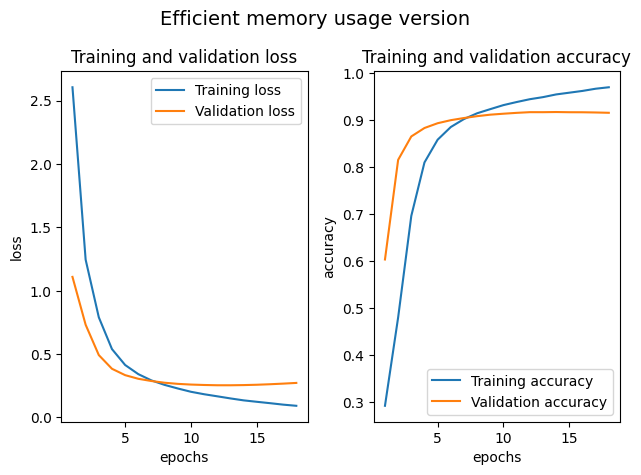

0.2533995807170868 The best number of epocs for the validation loss is 13
0.9174583554267883 The best number of epocs for the validation accuracy is 14


In [17]:
VOCAB_SIZE = 25000
num_heads = 4
dense_dim = 64

model = build_model(
    train_dataset,
    max_tokens=VOCAB_SIZE,
    dense_dim=dense_dim,
    num_heads=num_heads
)
history = model.fit(
    partial_train_dataset.map(tuplize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False),
    validation_data=val_dataset.map(tuplize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False),
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks =[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    ]
)
plot(history=history, title="Efficient memory usage version")

In [20]:
model = build_model(
    train_dataset,
    max_tokens=VOCAB_SIZE,
    dense_dim=dense_dim,
    num_heads=num_heads,
    name="transfomer_model"
)
model.fit(
    train_dataset.map(tuplize, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False),
    epochs=np.argmin(history.history["val_loss"]) + 1,
    batch_size=BATCH_SIZE,
)
test_loss, test_acc = model.evaluate(
    test_dataset.map(tuplize)
)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Model: "transfomer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_7 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 positional_embedding_4 (Po  (None, None, 128)         3328000   
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_6 (Tra  (None, None, 128)         280896    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_5 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_5 (Dropout)         (None, 128)          